# Gamma Ray Bursts

In [ ]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [75]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_15568\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [76]:
T90  = data[6]
T90_err = data[7]
T100 = data[12]
T10_err = data[13]
F    = data[9]
Ferr = data[10]
R    = data[11] 

In [77]:
def mask(X):
    # Elimina righe che contengono la stringa '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid]

    # Converte in float
    Y = Y.astype(float)

    # Elimina righe che contengono zero
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y_clean = Y[mask_nonzero]

    return Y_clean, Y_clean.shape[0]

I'd like to get the most data possible, even if I am not sure I'll get the most information out of them.

In [78]:
import itertools

In [79]:
array_list = [T90, T100, F, R]
array_labels = ['T90', 'T100', 'F', 'R']

# Ottieni tutte le coppie (combinazioni di 2)
array_pairs = list(itertools.combinations(array_list, 2))
label_pairs = list(itertools.combinations(array_labels, 2))

# Ciclo su tutte le coppie
for i, ((a1, a2), (label1, label2)) in enumerate(zip(array_pairs, label_pairs)):
    X = np.vstack([a1, a2]).T
    _, size = mask(X)
    print(f"{label1}-{label2}: {size} valid entries")

T90-T100: 7629 valid entries
T90-F: 7511 valid entries
T90-R: 597 valid entries
T100-F: 7511 valid entries
T100-R: 597 valid entries
F-R: 608 valid entries


In [80]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)

I want to look at relative errors

Text(0, 0.5, 'Flux ')

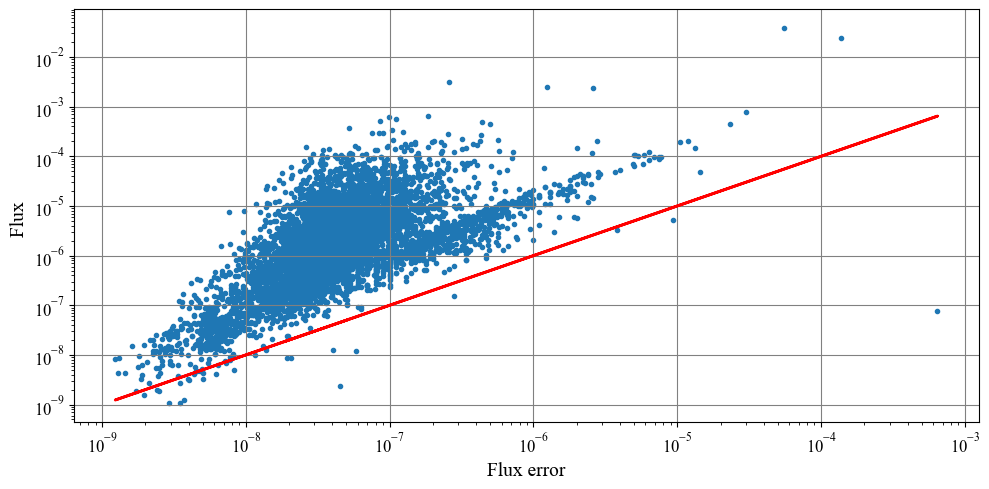

In [81]:
plt.scatter(Y.T[1], Y.T[0], marker='.')
plt.plot(Y.T[1], Y.T[1], lw=2, color='red')
plt.loglog()
plt.xlabel('Flux error')
plt.ylabel('Flux ')

Text(0, 0.5, 'T_90 ')

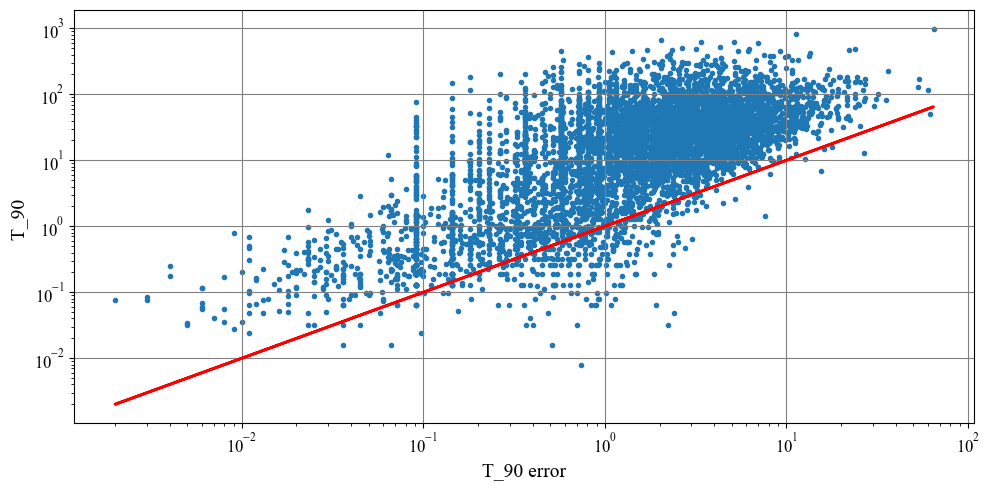

In [82]:
plt.scatter(Y.T[3], Y.T[2], marker='.')
plt.plot(Y.T[3], Y.T[3], lw=2, color='red')
plt.loglog()
plt.xlabel('T_90 error')
plt.ylabel('T_90 ')

All of the points appearing under the red line exhibit relative error bigger then 100%, thus they have to be discarded.

In [83]:
def mask2(X):
    # Elimina righe con valori mancanti '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid].astype(float)

    # Elimina righe con zeri
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y = Y[mask_nonzero]

    # Filtro: errore minore o uguale al valore misurato
    F, Ferr, T90, T90_err = Y.T  # unpack colonne
    mask_err_valid = (Ferr <= F) & (T90_err <= T90)

    Y_clean = Y[mask_err_valid]

    return Y_clean, Y_clean.shape[0]

In [84]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)